In [1]:
import pandas as pd
import numpy as np
import ast
import csv
import time
import random
import seaborn as sns

from operator import itemgetter
import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt

In [2]:
### from google.colab import drive
### drive.mount('/content/drive')

In [3]:
users=np.zeros((40000,1))

In [4]:
users.shape

(40000, 1)

In [5]:
user_friends={}
user_tags={}
max_friends=0
min_friends=200000
def hasMoreTags(s):
    return s[-1]!=']'

# Generate User: Tags dict

In [6]:
start=time.time()
with open('data.csv', 'r') as infile:
    reader = csv.reader(infile)
    count=-1
    
    for row in reader:
        #print(row[:7])
        count += 1
        if count == 0:
            continue
        id=row[0]
        #print(count)
        users[count-1][0]=id
        screenName=row[1]
        
        many_tags=hasMoreTags(row[2])
        
        offset=0
        #print('{} originally'.format(row[2]))
        #print(row[3])
        if many_tags:
            this_tags=[]
            for j in range(20):
                this_tags.append(row[2+j].strip('[]').strip(''))
                if row[2+j][-1]==']':
                    break
            #print('{} many tags'.format(this_tags))
            user_tags[id]=this_tags
            offset=len(this_tags)-1
            #print(offset)
        else:
            user_tags[id]=row[2].strip('[]').strip('')
            
        #followersCount=row[4]
        #print(offset)
        friendsCount=int(row[5+offset])
        #print(row[5+offset])
        max_friends=max(max_friends,friendsCount)
        min_friends=min(min_friends,friendsCount)
        friends=row[9+offset:]
        friends[0]=friends[0].strip('[]')
        friends[-1]=friends[-1].strip('[]')
        friends=[i.replace('"', '') for i in friends]
        friends=[i.strip() for i in friends]
        user_friends[id]=friends
        #print("{} : {}".format(count, friends))
end=time.time()
print('{} seconds'.format(end-start))

17.697014331817627 seconds


In [7]:
print(max_friends)
print(min_friends)

238749
101


# Generate/Read all tags

In [8]:
import re
def remove_hashtag(raw_str):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",raw_str).split())

In [9]:
try:
    all_tags=pd.read_csv('all_tags_saved.csv')
except:
    all_tags=set()

    for u in user_tags:
        tags=user_tags[u]

        if type(tags) == str:
            all_tags.add(remove_hashtag(tags))
        else:
            for tag in tags:
                all_tags.add(remove_hashtag(tag))

    pd.DataFrame(list(all_tags)).to_csv('all_tags_saved.csv')

In [10]:
len(all_tags)

128

# Generate Tag: User dict

In [11]:
tag_users={}

In [12]:
for u in user_tags:
    tags=user_tags[u]
    if type(tags)==str:
        normalized_tag=remove_hashtag(tags)
        if normalized_tag in tag_users:
            cur_tags=tag_users[normalized_tag]
            cur_tags.append(u)
            tag_users[normalized_tag]=cur_tags
        else:
            cur_tags=[]
            cur_tags.append(u)
            tag_users[normalized_tag]=cur_tags
    else:
        for tag in tags:
            normalized_tag=remove_hashtag(tag)
            if normalized_tag in tag_users:
                cur_tags=tag_users[normalized_tag]
                cur_tags.append(u)
                tag_users[normalized_tag]=cur_tags
            else:
                cur_tags=[]
                cur_tags.append(u)
                tag_users[normalized_tag]=cur_tags

In [35]:
print(len(tag_users))
#print(tag_users)


128


In [14]:
x=list(tag_users.keys())
y=[len(item) for item in tag_users.values()]

tag_nums=pd.DataFrame({'tags':x,'num':y})

# Sort by the num of each tag
sorted_tag_nums=tag_nums.sort_values(by=['num'], ascending=[0])

In [15]:
sorted_tag_nums[:10]

,tags,num
0,nationaldogday,30513
17,respecttylerjoseph,6054
2,gloryoutnow,600
8,backtohogwarts,310
1,narcos,269
76,steve rogers,211
31,louisweloveyou,142
24,bournemouth,130
69,bundesliga,122
27,harry potter,103


In [16]:
sorted_x=sorted_tag_nums['tags'][:5]
sorted_y=sorted_tag_nums['num'][:5]

In [17]:
list(sorted_x)

['nationaldogday',
 'respecttylerjoseph',
 'gloryoutnow',
 'backtohogwarts',
 'narcos']

c:\users\astr010gos\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


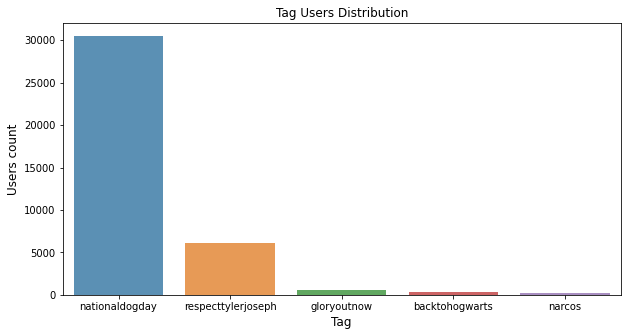

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(sorted_x, sorted_y, alpha=0.8)

plt.title('Tag Users Distribution')

plt.ylabel('Users count', fontsize=12)
plt.xlabel('Tag', fontsize=12)

plt.savefig('Graphs/tag_users.png')

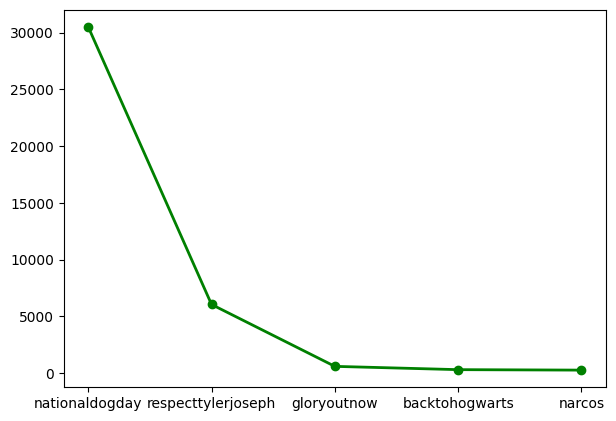

In [22]:
fig, axes = plt.subplots(figsize=(7,5), dpi=100)

plt.plot(sorted_x, sorted_y,'go-', label='line 1', linewidth=2)

In [23]:
# Generate the nodes and edges
nodes=user_friends.keys()
len(nodes)

40000

In [24]:
node_list=list(nodes)
with open('nodelist.txt', 'w') as filehandle:
    for listitem in node_list:
        filehandle.write('%s\n' % listitem)

# Built the network

In [25]:
def calculate_shortest_dist(this_tag, k_nodes):
    count=1
    size_k=len(k_nodes)
    for index_a in range(size_k):

        no_paths=[]
        shortest_path_list=[]
        shortest_dist=[]

        for index_b in range(index_a+1, size_k):
            a=k_nodes[index_a]
            b=k_nodes[index_b]

            try:
                s_path=nx.shortest_path_length(G,a,b)
                shortest_path_list.append((a,b,s_path))
                shortest_dist.append(s_path)

            except:
                no_paths.append((a,b))

        with open('temp/%s_shortest_path.txt'%this_tag,'a+') as fp:
            fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

        with open('temp/%s_shortest_path.txt'%this_tag,'a+') as fp:
            fp.write('\n')

        with open('temp/%s_no_path.txt'%this_tag,'a+') as fp:
            fp.write('\n'.join('%s %s'%x for x in no_paths))

        with open('temp/%s_no_path.txt'%this_tag,'a+') as fp:
            fp.write('\n')
  
        with open('temp/%s_shortest_dist.txt'%this_tag,'a+') as fp:
            fp.write('\n'.join('%s'%x for x in shortest_dist))

        with open('temp/%s_shortest_dist.txt'%this_tag,'a+') as fp:
            fp.write('\n')

        #print('Finished {} node'.format(count))
        count+=1

# Calculate Six Degrees under the same tag

In [26]:
top_tags=list(sorted_x)

# Sample 200 user from top 5 tags to calculate 6 degree
k=200
try:

  f=open('%s_shortest_path.txt'%top_tags[0])

except IOError:
# Calculate
  for this_tag in top_tags:
    this_tag_users=set(tag_users[this_tag])
    this_tag_users_list=list(this_tag_users)
    k_nodes=set() #should not choose the same node twice

    while len(k_nodes)<k:
      n1=random.choice(this_tag_users_list)
      if n1 not in k_nodes:
        k_nodes.add(n1)
    #print(len(k_nodes))
    calculate_shortest_dist(this_tag,list(k_nodes))

# Analyze top 5 tags

In [27]:
try:
    
    f=open('temp/%s_shortest_dist.txt'%top_tags[0])
    
except IOError: 
    for this_tag in top_tags:

        shortest_dist_list = pd.read_csv('%s_shortest_dist.txt'%this_tag, names=['dist'], sep=" ", header=None)

        shortest_dist_list['dist'].value_counts().to_csv('%s_info.txt'%this_tag,sep=':')
        shortest_dist_list.describe().to_csv('%s_info.txt'%this_tag, mode='a',sep=':')

# Visualize the results

In [29]:
for this_tag in top_tags:
    shortest_dist_tag_list=pd.read_csv('temp/%s_shortest_dist.txt'%this_tag,names=['dist'],sep=" ",header=None)

    sd_count=shortest_dist_tag_list['dist'].value_counts()
    
    plt.figure(figsize=(10,5))
    sns.barplot(sd_count.index, sd_count.values, alpha=0.8)

    plt.title('%s'%this_tag)
    plt.ylabel('Pair count', fontsize=12)
    plt.xlabel('Shortest Distance', fontsize=12)
    #plt.show()
    plt.savefig('Graphys/%s.png'%this_tag)

c:\users\astr010gos\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: min() arg is an empty sequence

<Figure size 720x360 with 0 Axes>

# Read the graph

In [32]:
begin=time.time()
try:
  nx.write_gpickle(G,"test.gpickle")
  # Read from pickle
  G=nx.read_gpickle("test.gpickle")
  end=time.time()
  print('Spent {} in reading graph'.format(end-begin))
except:
  G=nx.Graph()
  G.add_edges_from(edges)
  end=time.time()
  print('{} seconds'.format(end-start))

Spent 0.004004001617431641 in reading graph


In [33]:
########### Print the summary of the graph ###########
print(nx.info(G))

Graph with 0 nodes and 0 edges


# (Without Tags) Calculate the shortest path

In [ ]:
#### Only Need to Calculate Once, more than 10 hours ####
#################### Select k nodes #####################
node_list=[line.rstrip('\n') for line in open('../six-degrees-of-separation-in-twitter-master/nodelist.txt')]

k=5000
k_nodes=set()

while len(k_nodes)<k:
    n1=random.choice(node_list)
    if n1 not in k_nodes:
        k_nodes.add(n1)

print('Finished sampling {} nodes'.format(k))

k_nodes=list(k_nodes)

count=1
pairs_count=0

for index_a in range(k):
    no_paths=[]
    shortest_path_list=[]
    shortest_dist=[]

    for index_b in range(index_a+1,k):
        pairs_count+=1
        a=k_nodes[index_a]
        b=k_nodes[index_b]

        try:
            s_path=nx.shortest_path_length(G,a,b)
            shortest_path_list.append((a,b,s_path))
            shortest_dist.append(s_path)

        except:
            no_paths.append((a,b))

    with open('../six-degrees-of-separation-in-twitter-master/real_%s_shortest_path.txt'%k,'a+') as fp:
        fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

    with open('../six-degrees-of-separation-in-twitter-master/real_%s_no_path.txt'%k,'a+') as fp:
        fp.write('\n'.join('%s %s'%x for x in no_paths))

    with open('../six-degrees-of-separation-in-twitter-master/real_%s_shortest_dist.txt'%k,'a+') as fp:
        fp.write('\n'.join('%s'%x for x in shortest_dist))

    print('Finished {} node'.format(count))
    count+=1

# (Withou Tags) Analyze the data 5000 users

In [ ]:
shortest_dist_list = pd.read_csv('../six-degrees-of-separation-in-twitter-master/5000_shortest_dist.txt', names=['dist'], sep=" ", header=None)

In [ ]:
shortest_dist_list['dist'].value_counts()

In [ ]:
shortest_dist_list['dist'].count()

In [ ]:
sd_count=shortest_dist_list['dist'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(sd_count.index, sd_count.values, alpha=0.8)

plt.title('5000 Users Degrees Distribution')
plt.ylabel('Pair count', fontsize=12)
plt.xlabel('Shortest Distance', fontsize=12)
plt.savefig('/content/drive/My Drive/network/5000_users.png')

In [ ]:
degree_greater_than_6=sum(sd_count.loc[sd_count.index>6].values)
print("Pairs that have degree greater than 6 has {}".format(degree_greater_than_6))

In [ ]:
degree_smaller_than_6=sum(sd_count.loc[sd_count.index<6].values)
print("Pairs that have degree smaller than 6 has {}".format(degree_smaller_than_6))

In [ ]:
degree_equal_to_6=sum(sd_count.loc[sd_count.index==6].values)
print("Pairs that have degree equal to 6 has {}".format(degree_equal_to_6))

In [ ]:
# Visualization
x_dist=['Smaller than 6', 'Equal to 6', 'Larger than 6']
y_count=[degree_smaller_than_6, degree_equal_to_6 ,degree_greater_than_6]

plt.figure(figsize=(10,5))

sns.barplot(x_dist, y_count, alpha=0.8)

plt.title('Six Degrees Distribution')

plt.ylabel('Pair count', fontsize=12)
plt.xlabel('Shortest Distance', fontsize=12)
plt.savefig('/content/drive/My Drive/network/six_degrees_distribution.png')

In [ ]:
shortest_dist_list.describe()

# (Withou Tags) Analyze the data 10000 users

In [ ]:
shortest_dist_list = pd.read_csv('/content/drive/My Drive/network/10000_shortest_dist.txt', names=['dist'], sep=" ", header=None)

In [ ]:
shortest_dist_list['dist'].value_counts()

In [ ]:
shortest_dist_list['dist'].count()

In [ ]:
sd_count=shortest_dist_list['dist'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(sd_count.index, sd_count.values, alpha=0.8)

plt.title('10000 Users Degrees Distribution')
plt.ylabel('Pair count', fontsize=12)
plt.xlabel('Shortest Distance', fontsize=12)
plt.savefig('/content/drive/My Drive/network/10000_users.png')

In [ ]:
degree_greater_than_6=sum(sd_count.loc[sd_count.index>6].values)
print("Pairs that have degree greater than 6 has {}".format(degree_greater_than_6))

In [ ]:
degree_smaller_than_6=sum(sd_count.loc[sd_count.index<6].values)
print("Pairs that have degree smaller than 6 has {}".format(degree_smaller_than_6))

In [ ]:
degree_equal_to_6=sum(sd_count.loc[sd_count.index==6].values)
print("Pairs that have degree equal to 6 has {}".format(degree_equal_to_6))

In [ ]:
# Visualization
x_dist=['Smaller than 6', 'Equal to 6', 'Larger than 6']
y_count=[degree_smaller_than_6, degree_equal_to_6 ,degree_greater_than_6]

plt.figure(figsize=(10,5))

sns.barplot(x_dist, y_count, alpha=0.8)

plt.title('Six Degrees Distribution')

plt.ylabel('Pair count', fontsize=12)
plt.xlabel('Shortest Distance', fontsize=12)
plt.savefig('/content/drive/My Drive/network/six_degrees_distribution_10000.png')

In [ ]:
shortest_dist_list.describe()